In [1]:
import numpy as np
import nibabel as nb
import SimpleITK as sitk
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from loguru import logger
import sys
import maximum_expectation_algorithm
import random
import pandas as pd

In [2]:
EM = maximum_expectation_algorithm.maximum_expectation_algorithm()

In [3]:
root_dir = '../Register_testing_volumes/mni_atlas_REGISTERED_AFFINE10/'
root_dir_3 = '../Register_testing_volumes/mni_atlas2/'
root_dir_2 = '../Register_testing_volumes/test/test/'
# 
results = []
directories = [
    #"1003","1004","1005","1018", "1019",
    #"1023","1024","1025","1039",
    "1101", "1104", "1107", "1110", "1113",
    #"1116", "1119", "1122", "1125", "1128"
]

images_results_2_1 = {}
images_results_2_2 = {}

for directory in directories:
    print(f'------------ Cases {directory} ---------------------')

    # Read images
    background = sitk.ReadImage(os.path.join(root_dir,directory,'mni_atlas_p_atlas_background.nii'))
    csf = sitk.ReadImage(os.path.join(root_dir,directory,'mni_atlas_p_atlas_csf.nii'))
    gm = sitk.ReadImage(os.path.join(root_dir,directory,'mni_atlas_p_atlas_gm.nii'))
    wm = sitk.ReadImage(os.path.join(root_dir,directory,'mni_atlas_p_atlas_wm.nii'))
    t1 = sitk.ReadImage(os.path.join(root_dir_2,'testing-images',f'{directory}.nii.gz'))
    t1_mask = sitk.ReadImage(os.path.join(root_dir_2,'testing-mask',f'{directory}_1C.nii.gz'))
    gt = sitk.ReadImage(os.path.join(root_dir_2,'testing-labels',f'{directory}_3C.nii.gz'))
    
    csf_mni = sitk.ReadImage(os.path.join(root_dir_3,directory,'mni_atlas_p_atlas_csf.nii'))
    gm_mni = sitk.ReadImage(os.path.join(root_dir_3,directory,'mni_atlas_p_atlas_gm.nii'))
    wm_mni  = sitk.ReadImage(os.path.join(root_dir_3,directory,'mni_atlas_p_atlas_wm.nii'))
    
    # Convert images to arrays
    background = sitk.GetArrayFromImage(background)
    csf = sitk.GetArrayFromImage(csf)
    gm = sitk.GetArrayFromImage(gm)
    wm = sitk.GetArrayFromImage(wm)
    t1 = sitk.GetArrayFromImage(t1)
    t1_mask = sitk.GetArrayFromImage(t1_mask)
    gt = sitk.GetArrayFromImage(gt)
    #print(np.unique(gt))
    csf_mni = sitk.GetArrayFromImage(csf_mni)
    gm_mni = sitk.GetArrayFromImage(gm_mni)
    wm_mni = sitk.GetArrayFromImage(wm_mni)

    brain_mask_array = np.where(gt > 0, 255, 0).astype('uint8')
    
    t1 = EM.min_max_norm(t1, 255, None, 'uint8')

    our_atlas = np.stack([csf,gm,wm],axis=0)
    mni_atlas = np.stack([csf_mni,gm_mni,wm_mni],axis=0)
    
    tm = np.load('tissue_models.npy')
    
    # 2.1
    t1_segmentation_k, t1_segmentation_time_k = EM.tissue_segmentation(t1,t1_mask,type='knn')
    t1_segmentation_k = EM.match_pred_with_gt(t1_segmentation_k, gt)
    
    t1_segmentation_ours, t1_segmentation_time_ours = EM.tissue_segmentation(t1,t1_mask,type='label_propragation',label_pro=our_atlas)
    t1_segmentation_ours = EM.match_pred_with_gt(t1_segmentation_ours, gt)

    t1_segmentation_mni, t1_segmentation_time_mni = EM.tissue_segmentation(t1,t1_mask,type='label_propragation',label_pro=mni_atlas)
    t1_segmentation_mni = EM.match_pred_with_gt(t1_segmentation_mni, gt)
    
    T = tm[1:, :]
    t1_segmentation_tissue, t1_segmentation_time_tissue = EM.tissue_segmentation(t1,t1_mask,type='tissue_model',label_pro=our_atlas,tissue_model=T)
    t1_segmentation_mni = EM.match_pred_with_gt(t1_segmentation_tissue, gt)

    #2.2 Elegir el mejor into y after
    t1_segmentation_ours_into, t1_segmentation_time_ours_into = EM.tissue_segmentation(t1,t1_mask,type='label_propragation',label_pro=our_atlas,atlas_use='into')
    t1_segmentation_ours_into = EM.match_pred_with_gt(t1_segmentation_ours_into, gt)

    t1_segmentation_ours_after, t1_segmentation_time_ours_after = EM.tissue_segmentation(t1,t1_mask,type='label_propragation',label_pro=our_atlas,atlas_use='after')
    t1_segmentation_ours_after = EM.match_pred_with_gt(t1_segmentation_ours_after, gt)
    
    #print(f'Etiquetas en Gt: {np.unique(gt)}')
    #print(f'Etiquetas en atlas Segmentation: {np.unique(t1_segmentation_ours)}')

    
    results.append( EM.dice_score(gt, t1_segmentation_k ) + [directory,'K-Means',None,t1_segmentation_time_k])
    results.append( EM.dice_score(gt, t1_segmentation_ours ) + [directory,'Atlas',None,t1_segmentation_time_ours])
    results.append( EM.dice_score(gt, t1_segmentation_mni ) + [directory,'MNI_Atlas',None,t1_segmentation_time_mni])
    results.append( EM.dice_score(gt, t1_segmentation_tissue ) + [directory,'tissue_model',None,t1_segmentation_time_tissue])
    results.append( EM.dice_score(gt, t1_segmentation_ours_into ) + [directory,'Atlas','Into',t1_segmentation_time_ours_into])
    results.append( EM.dice_score(gt, t1_segmentation_ours_after ) + [directory,'Atlas','After',t1_segmentation_time_ours_after])
    
    images_results_2_1[directory] = [
        gt,
        t1_segmentation_k,
        t1_segmentation_ours,
        t1_segmentation_mni,
        t1_segmentation_tissue,
        ]
    images_results_2_2[directory] = [
       gt,
       t1_segmentation_ours,
       t1_segmentation_ours_into,
        t1_segmentation_ours_after,
        ]
# Create a dataframe to store the results

labels = ['CSF', 'GM', 'WM', 'Subject', 'Init','Atlas_use','Time']
results = pd.DataFrame(data=results, columns=labels)
results

------------ Cases 1101 ---------------------


EM in progress with knn init and None atlas: 100%|██████████| 300/300 [01:36<00:00,  3.09it/s]
EM in progress with label_propragation init and None atlas:   3%|▎         | 8/300 [00:03<01:56,  2.52it/s]
EM in progress with label_propragation init and None atlas:   3%|▎         | 8/300 [00:03<02:04,  2.35it/s]
EM in progress with tissue_model init and None atlas: 100%|██████████| 300/300 [01:47<00:00,  2.80it/s]
EM in progress with label_propragation init and into atlas: 100%|██████████| 300/300 [01:57<00:00,  2.56it/s]
EM in progress with label_propragation init and after atlas:   3%|▎         | 8/300 [00:02<01:37,  2.98it/s]


------------ Cases 1104 ---------------------


EM in progress with knn init and None atlas: 100%|██████████| 300/300 [01:27<00:00,  3.44it/s]
EM in progress with label_propragation init and None atlas: 100%|██████████| 300/300 [01:30<00:00,  3.33it/s]
EM in progress with label_propragation init and None atlas: 100%|██████████| 300/300 [01:27<00:00,  3.44it/s]
EM in progress with tissue_model init and None atlas: 100%|██████████| 300/300 [01:29<00:00,  3.35it/s]
EM in progress with label_propragation init and into atlas: 100%|██████████| 300/300 [01:57<00:00,  2.55it/s]
EM in progress with label_propragation init and after atlas: 100%|██████████| 300/300 [01:27<00:00,  3.43it/s]


------------ Cases 1107 ---------------------


EM in progress with knn init and None atlas: 100%|██████████| 300/300 [01:14<00:00,  4.04it/s]
EM in progress with label_propragation init and None atlas:   2%|▏         | 7/300 [00:01<01:22,  3.55it/s]
EM in progress with label_propragation init and None atlas:   2%|▏         | 7/300 [00:01<01:21,  3.61it/s]
EM in progress with tissue_model init and None atlas: 100%|██████████| 300/300 [01:14<00:00,  4.03it/s]
EM in progress with label_propragation init and into atlas: 100%|██████████| 300/300 [01:30<00:00,  3.30it/s]
EM in progress with label_propragation init and after atlas:   2%|▏         | 7/300 [00:01<01:23,  3.51it/s]


------------ Cases 1110 ---------------------


EM in progress with knn init and None atlas: 100%|██████████| 300/300 [01:20<00:00,  3.72it/s]
EM in progress with label_propragation init and None atlas:   2%|▏         | 6/300 [00:01<01:36,  3.06it/s]
EM in progress with label_propragation init and None atlas:   2%|▏         | 6/300 [00:02<01:45,  2.78it/s]
EM in progress with tissue_model init and None atlas: 100%|██████████| 300/300 [01:20<00:00,  3.73it/s]
EM in progress with label_propragation init and into atlas: 100%|██████████| 300/300 [01:42<00:00,  2.92it/s]
EM in progress with label_propragation init and after atlas:   2%|▏         | 6/300 [00:02<01:38,  2.97it/s]


------------ Cases 1113 ---------------------


EM in progress with knn init and None atlas: 100%|██████████| 300/300 [01:23<00:00,  3.59it/s]
EM in progress with label_propragation init and None atlas: 100%|██████████| 300/300 [01:26<00:00,  3.48it/s]
EM in progress with label_propragation init and None atlas: 100%|██████████| 300/300 [01:32<00:00,  3.24it/s]
EM in progress with tissue_model init and None atlas: 100%|██████████| 300/300 [01:35<00:00,  3.14it/s]
EM in progress with label_propragation init and into atlas: 100%|██████████| 300/300 [01:52<00:00,  2.66it/s]
EM in progress with label_propragation init and after atlas: 100%|██████████| 300/300 [01:37<00:00,  3.08it/s]


,CSF,GM,WM,Subject,Init,Atlas_use,Time
0,0.708178,0.877150,0.928849,1101,K-Means,None,97.270223
1,0.000000,0.810718,0.824702,1101,Atlas,None,3.463885
2,0.558801,0.862346,0.920648,1101,MNI_Atlas,None,3.704549
3,0.558801,0.862346,0.920648,1101,tissue_model,None,107.390028
4,0.134162,0.682240,0.753719,1101,Atlas,Into,117.561578
5,0.027177,0.000000,0.677553,1101,Atlas,After,2.953128
6,0.000089,0.777309,0.923211,1104,K-Means,None,87.423379
7,0.000000,0.802645,0.832968,1104,Atlas,None,90.396266
8,0.421817,0.880145,0.932051,1104,MNI_Atlas,None,87.635049
9,0.421817,0.880145,0.932051,1104,tissue_model,None,89.720058


## Plotting the results for Segmentation

Images of EM 1101 with slice 130


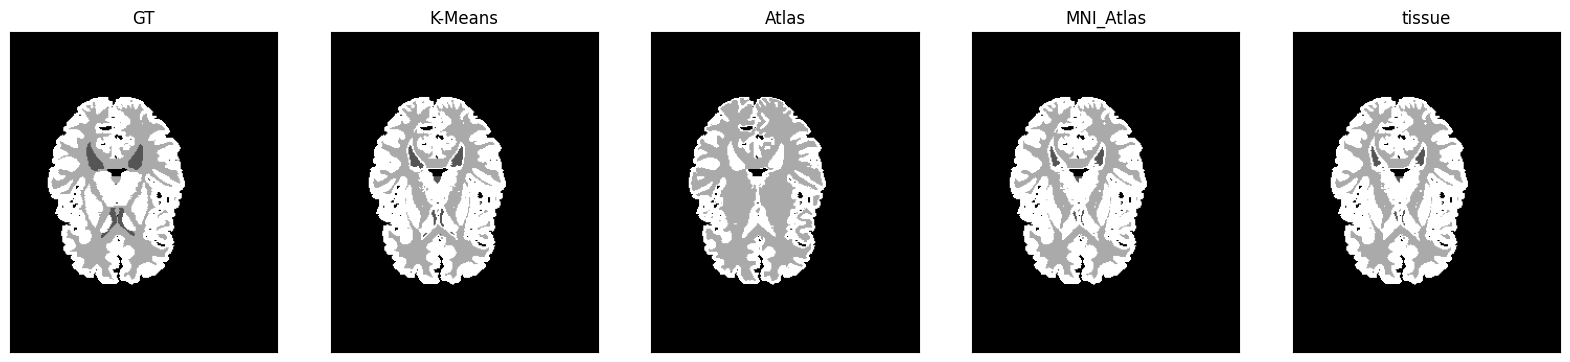

Images of EM 1104 with slice 130


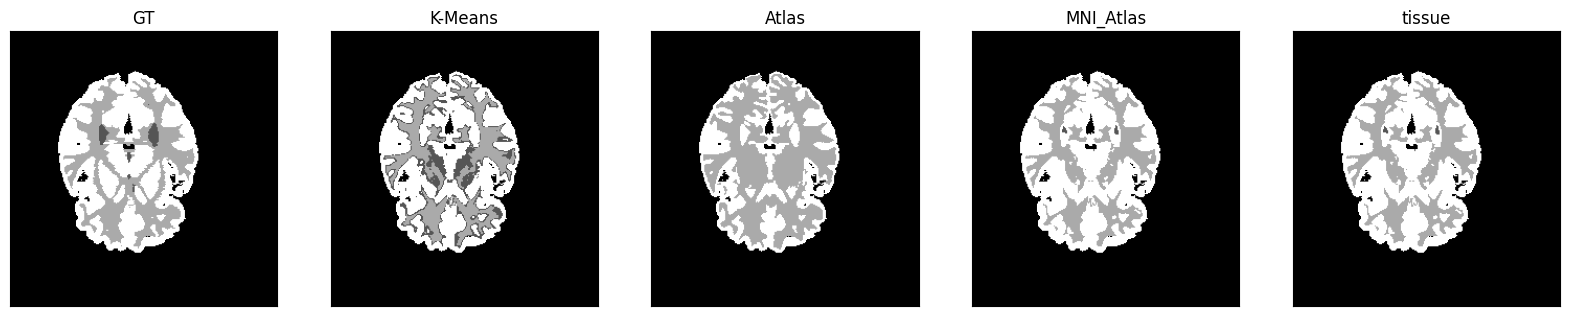

Images of EM 1107 with slice 130


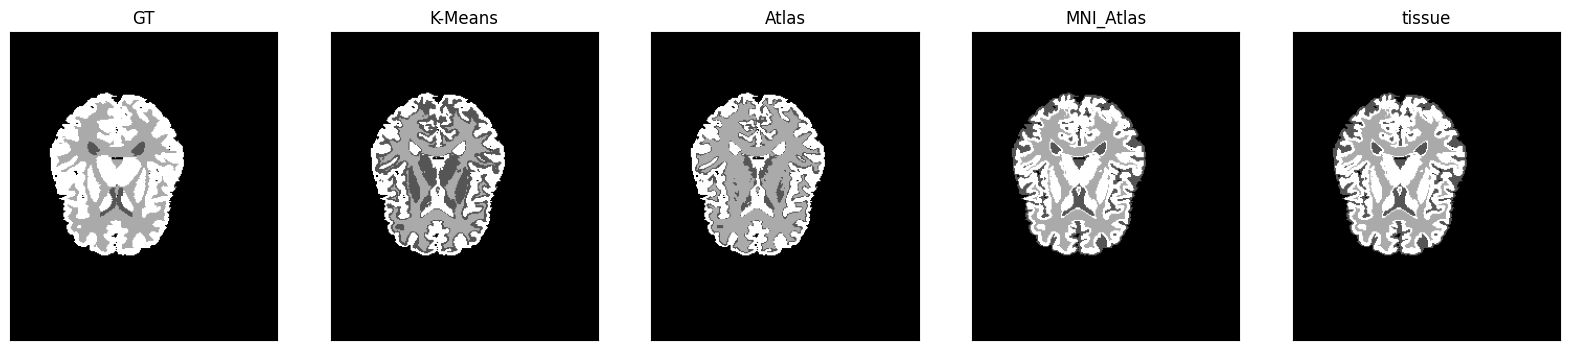

Images of EM 1110 with slice 130


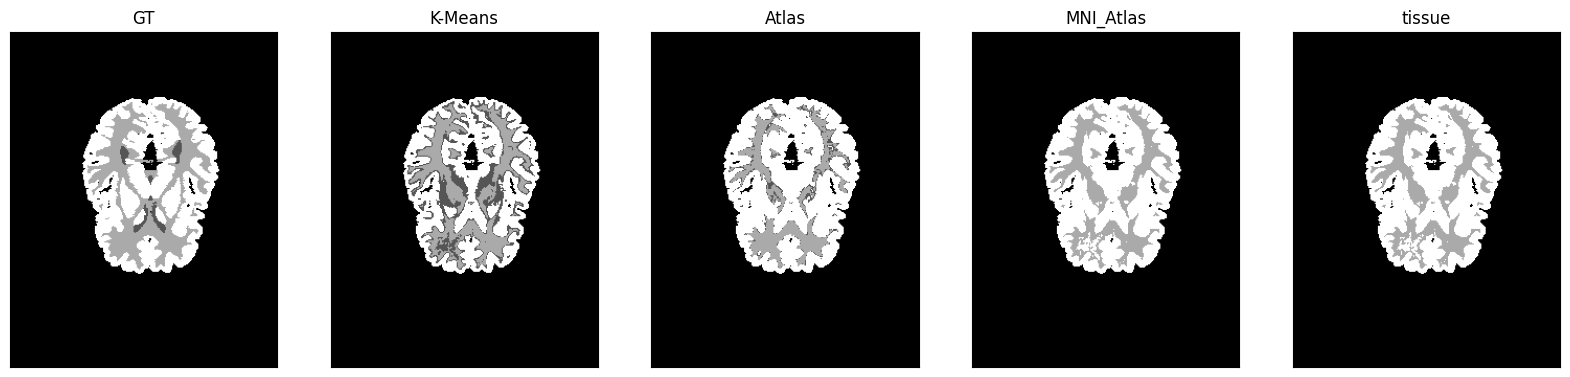

Images of EM 1113 with slice 130


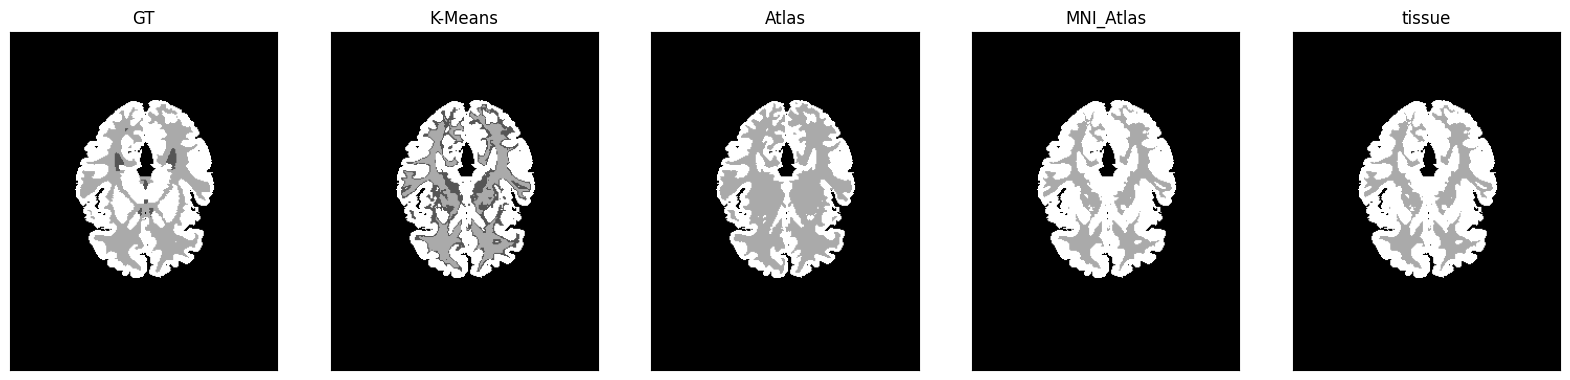

In [8]:
slice = 130


names = ['GT','K-Means','Atlas','MNI_Atlas','tissue']
for directory in directories:
    
    print(f'Images of EM {directory} with slice {slice}')
    EM.get_plots(images_results_2_1[directory], names, slice_to_display = slice)
    

## Plotting the results for into/after Atlas

Images of EM 1101 with slice 130


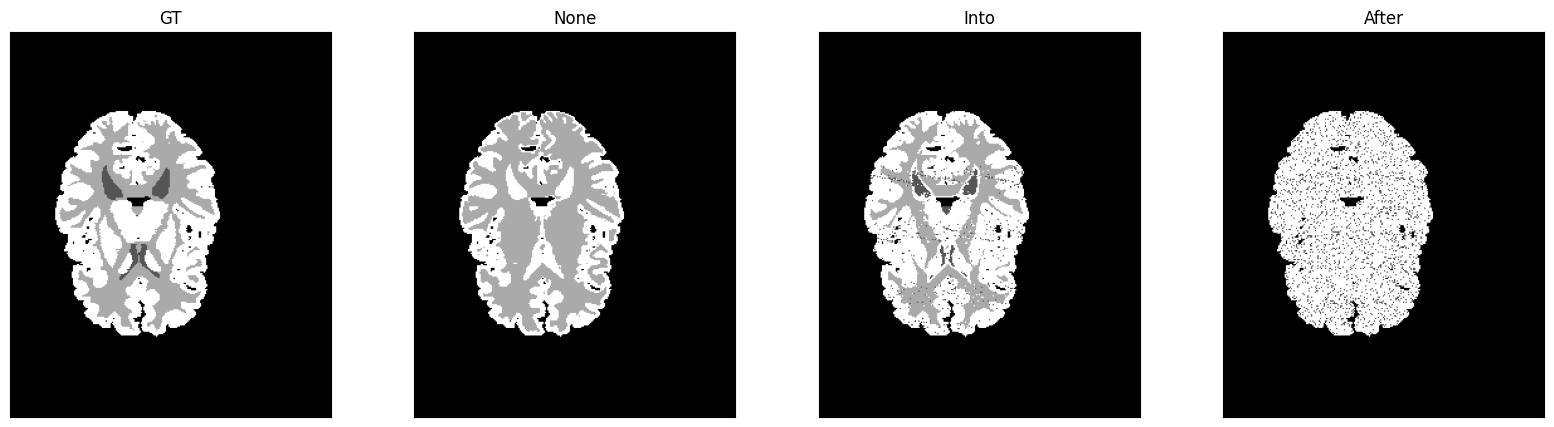

Images of EM 1104 with slice 130


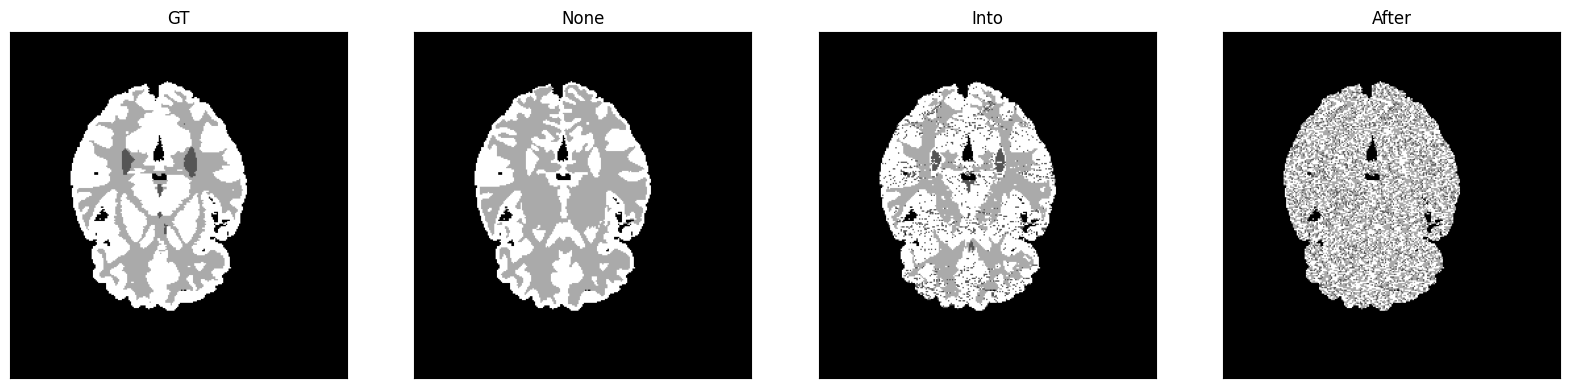

Images of EM 1107 with slice 130


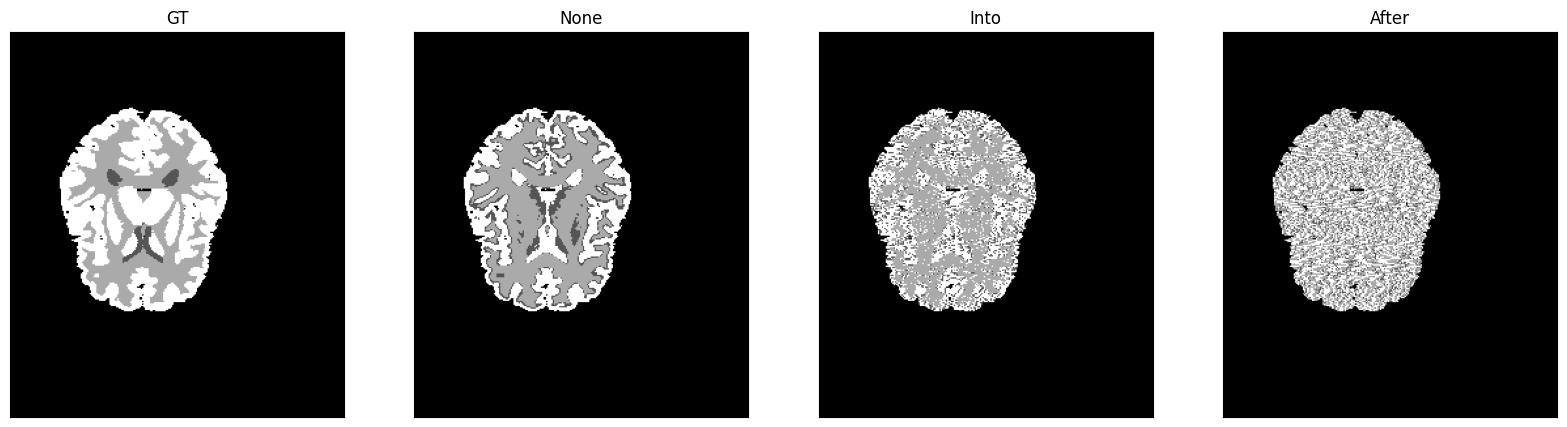

Images of EM 1110 with slice 130


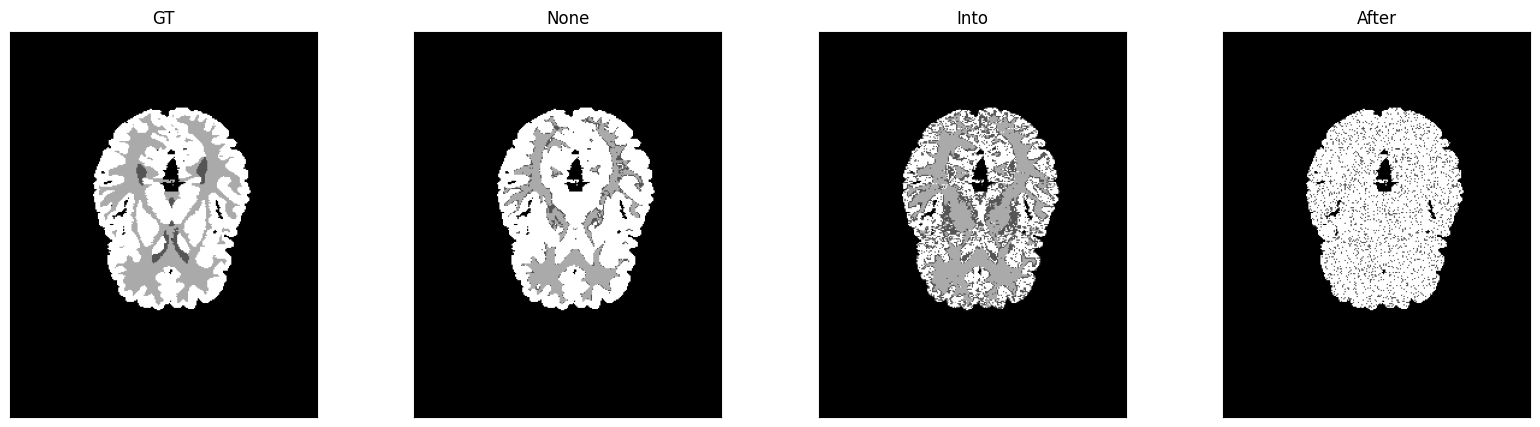

Images of EM 1113 with slice 130


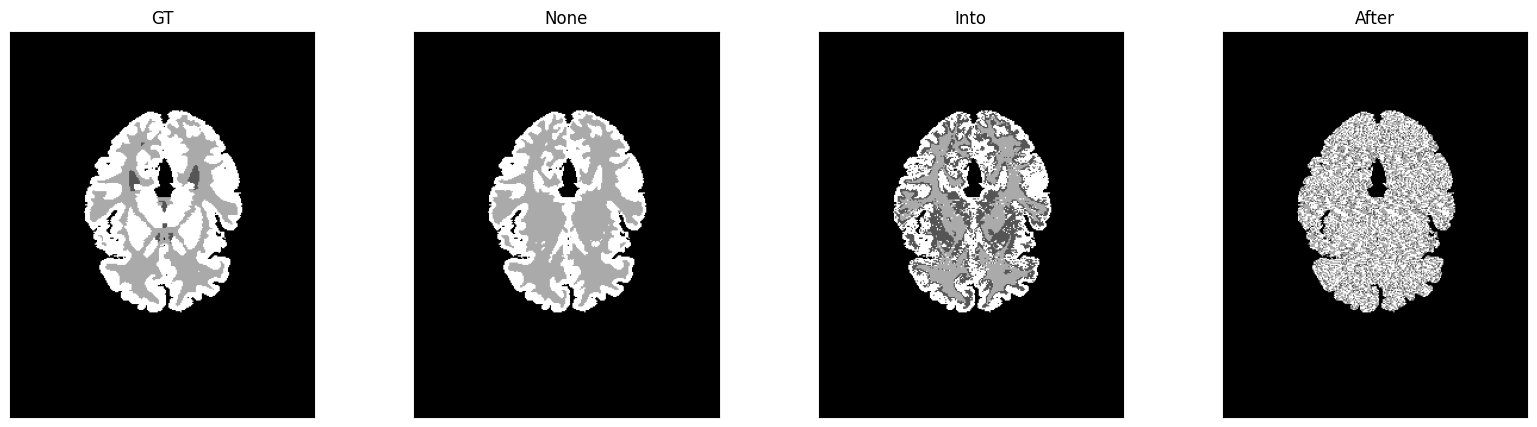

In [9]:
slice = 130

names = ['GT','None','Into','After']
for directory in directories:
    
    print(f'Images of EM {directory} with slice {slice}')
    EM.get_plots(images_results_2_2[directory], names, slice_to_display = slice)

## Dice Values from the Segmentation

In [10]:
filtered_results = results[results['Atlas_use'].isna()]
average_values = filtered_results.groupby('Init')[['CSF', 'GM', 'WM']].mean().reset_index()
average_values

,Init,CSF,GM,WM
0,Atlas,0.002167,0.806278,0.846498
1,K-Means,0.143972,0.788546,0.901901
2,MNI_Atlas,0.213070,0.838686,0.868279
3,tissue_model,0.213070,0.838686,0.868279


In [11]:
filtered_results = results[results['Init'].str.contains("Atlas")]
average_values = filtered_results.groupby('Atlas_use')[['CSF', 'GM', 'WM']].mean().reset_index()
average_values

,Atlas_use,CSF,GM,WM
0,After,0.023914,0.241265,0.561533
1,Into,0.063087,0.698581,0.686387
